In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, year, unix_timestamp, col, udf
from pyspark.sql.types import DoubleType, IntegerType, TimestampType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import math

In [2]:
spark = SparkSession.builder \
    .appName("Taxi Fare Prediction") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "100s") \
    .getOrCreate()


In [3]:

csv_files_path = "hdfs://localhost:9000/Bigdata/*.csv"
combined_df = spark.read.csv(csv_files_path, header=True, inferSchema=True)


In [4]:
combined_df = combined_df.withColumn("passenger_count", combined_df["passenger_count"].cast(IntegerType())) \
    .withColumn("trip_distance", combined_df["trip_distance"].cast(DoubleType())) \
    .withColumn("pickup_longitude", combined_df["pickup_longitude"].cast(DoubleType())) \
    .withColumn("pickup_latitude", combined_df["pickup_latitude"].cast(DoubleType())) \
    .withColumn("dropoff_longitude", combined_df["dropoff_longitude"].cast(DoubleType())) \
    .withColumn("dropoff_latitude", combined_df["dropoff_latitude"].cast(DoubleType())) \
    .withColumn("fare_amount", combined_df["fare_amount"].cast(DoubleType())) \
    .withColumn("tpep_pickup_datetime", combined_df["tpep_pickup_datetime"].cast(TimestampType())) \
    .withColumn("tpep_dropoff_datetime", combined_df["tpep_dropoff_datetime"].cast(TimestampType()))


In [5]:
# Giả định rằng bạn đang phân tích dữ liệu cho tháng 1 năm 2015
jan_2015_df = combined_df.filter((col("tpep_pickup_datetime") >= "2015-01-01") & 
                                  (col("tpep_pickup_datetime") < "2015-02-01"))

In [6]:
from pyspark.sql.functions import hour, dayofweek, col

# Chuyển đổi tpep_pickup_datetime thành định dạng timestamp nếu chưa
jan_2015_df = jan_2015_df.withColumn("pickup_time", col("tpep_pickup_datetime").cast("timestamp"))

# Trích xuất giờ và ngày trong tuần
jan_2015_df = jan_2015_df.withColumn("hour", hour(col("pickup_time"))) \
                          .withColumn("day_of_week", dayofweek(col("pickup_time")))  # 1 = Chủ nhật, 7 = Thứ Bảy


In [12]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Định nghĩa cửa sổ cho phân tích theo giờ
window_spec = Window.partitionBy("hour")

# Tính giá vé trung bình và số lượng chuyến đi theo giờ
hourly_with_avg = jan_2015_df.withColumn("avg_fare_hourly", F.avg("fare_amount").over(window_spec)) \
    .withColumn("num_trips_hourly", F.count("tpep_pickup_datetime").over(window_spec))

# Chọn các cột cần thiết để hiển thị
hourly_analysis_with_window = hourly_with_avg.select("hour", "avg_fare_hourly", "num_trips_hourly").distinct()

hourly_analysis_with_window.show()


+----+------------------+----------------+
|hour|   avg_fare_hourly|num_trips_hourly|
+----+------------------+----------------+
|  12|11.358761480770719|          637479|
|  22|12.206558804819919|          686959|
|   1|12.566891579496323|          355145|
|  13|11.650855602773902|          635587|
|   6|12.865515449516856|          268455|
|  16| 12.11617298360423|          576598|
|   3|  13.0153351232094|          198524|
|  20|11.484409634417862|          733952|
|   5|15.644465029779253|          127437|
|  19| 11.11309634514377|          805230|
|  15|12.266217102829485|          648688|
|   9|11.468468641493658|          580034|
|  17|11.645774622826725|          668790|
|   4|14.622187532717467|          143271|
|   8|11.530594782503634|          561802|
|  23| 12.63818860994351|          592429|
|   7|11.763792452540775|          456127|
|  10|11.428874075848478|          567818|
|  21|11.888987687945026|          711579|
|  11|11.375431380175474|          596504|
+----+-----

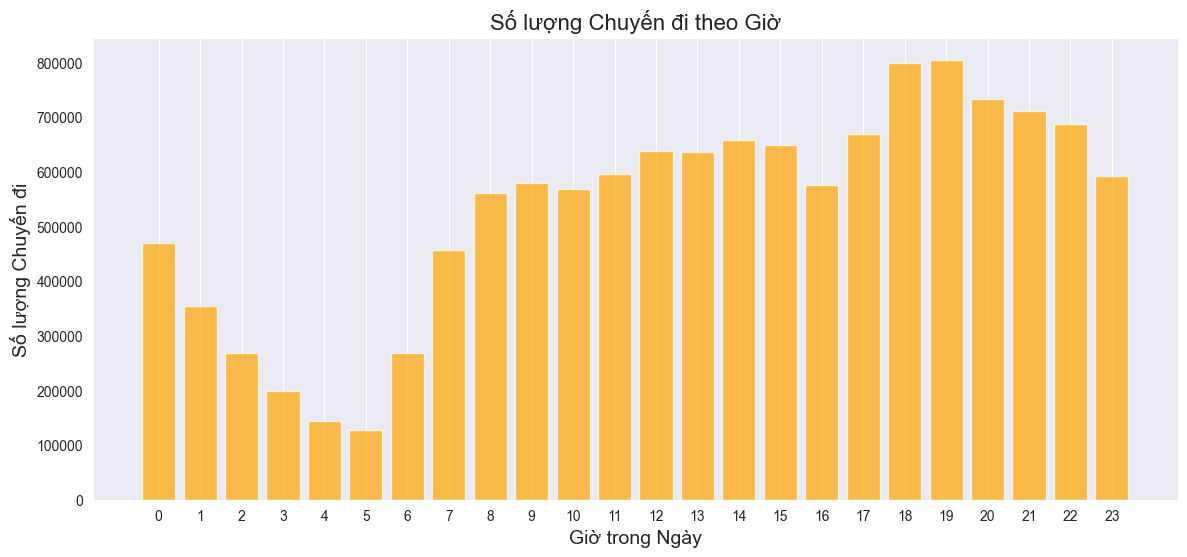

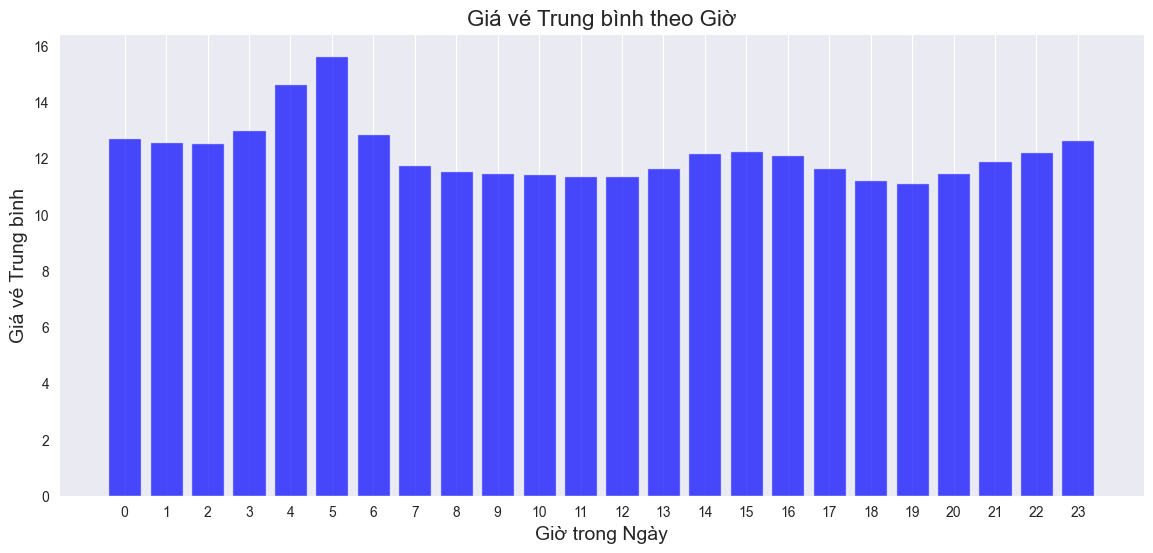

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Chuyển đổi sang Pandas DataFrame để vẽ biểu đồ
hourly_df = hourly_analysis_with_window.toPandas()

# Vẽ biểu đồ cho số lượng chuyến đi
plt.figure(figsize=(14, 6))
plt.bar(hourly_df['hour'], hourly_df['num_trips_hourly'], color='orange', alpha=0.7)
plt.title('Số lượng Chuyến đi theo Giờ năm 2015', fontsize=16)
plt.xlabel('Giờ trong Ngày', fontsize=14)
plt.ylabel('Số lượng Chuyến đi', fontsize=14)
plt.xticks(hourly_df['hour'])
plt.grid(axis='y')
plt.show()

# Vẽ biểu đồ cho giá vé trung bình
plt.figure(figsize=(14, 6))
plt.bar(hourly_df['hour'], hourly_df['avg_fare_hourly'], color='blue', alpha=0.7)
plt.title('Giá vé Trung bình theo Giờ năm 2015', fontsize=16)
plt.xlabel('Giờ trong Ngày', fontsize=14)
plt.ylabel('Giá vé Trung bình', fontsize=14)
plt.xticks(hourly_df['hour'])
plt.grid(axis='y')
plt.show()


In [17]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Khởi tạo Spark session nếu chưa có
spark = SparkSession.builder.appName("TaxiRevenueAnalysis").getOrCreate()

# Giả sử combined_df là DataFrame chứa dữ liệu đã đọc từ CSV
# Chuyển đổi cột tpep_pickup_datetime thành định dạng ngày
combined_df = combined_df.withColumn("pickup_date", col("tpep_pickup_datetime").cast("date"))

# Trích xuất năm và quý từ ngày
combined_df = combined_df.withColumn("year", F.year("pickup_date")) \
                         .withColumn("quarter", F.quarter("pickup_date"))

# Tính tổng doanh thu theo quý
quarterly_revenue = combined_df.groupBy("year", "quarter") \
    .agg(F.sum("total_amount").alias("total_revenue")) \
    .orderBy("year", "quarter")

# Hiển thị kết quả
quarterly_revenue.show()


+----+-------+-------------------+
|year|quarter|      total_revenue|
+----+-------+-------------------+
|2015|      1|5.960034159939752E8|
|2016|      1|5.441231699333514E8|
+----+-------+-------------------+



In [19]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Khởi tạo Spark session nếu chưa có
spark = SparkSession.builder.appName("TaxiRevenueAnalysis").getOrCreate()

# Giả sử combined_df là DataFrame chứa dữ liệu đã đọc từ CSV
# Chuyển đổi cột tpep_pickup_datetime thành định dạng ngày
combined_df = combined_df.withColumn("pickup_date", col("tpep_pickup_datetime").cast("date"))

# Trích xuất năm và tháng từ ngày
combined_df = combined_df.withColumn("year", F.year("pickup_date")) \
                         .withColumn("month", F.month("pickup_date"))

# Tính tổng doanh thu theo tháng cho từng năm
monthly_revenue = combined_df.groupBy("year", "month") \
    .agg(F.sum("total_amount").alias("total_revenue")) \
    .orderBy("year", "month")

# Hiển thị kết quả
monthly_revenue.show()


+----+-----+--------------------+
|year|month|       total_revenue|
+----+-----+--------------------+
|2015|    1| 1.926154355412053E8|
|2015|    2|1.9174712899128538E8|
|2015|    3|2.1164085146148437E8|
|2016|    1|1.7059847689100492E8|
|2016|    2|1.7758995919108796E8|
|2016|    3|1.9593473385125843E8|
+----+-----+--------------------+



In [20]:
spark.stop()